In [22]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [5]:
data = pd.read_csv('data/StudentsPerformance.csv')

In [6]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [9]:
X = data.drop(columns=['math score'],axis=1)
X

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75
...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,99,95
996,male,group C,high school,free/reduced,none,55,55
997,female,group C,high school,free/reduced,completed,71,65
998,female,group D,some college,standard,completed,78,77


In [12]:

print("Categories in 'gender' variable:     ",end=" " )
print(data['gender'].unique())

print("Categories in 'race/ethnicity' variable:  ",end=" ")
print(data['race/ethnicity'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(data['parental level of education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(data['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(data['test preparation course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race/ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [14]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [15]:
data['total_score'] = data['math score'] + data['reading score'] + data['writing score']
data['average'] = data['total_score']/3
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total_score,average
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.666667
1,female,group C,some college,standard,completed,69,90,88,247,82.333333
2,female,group B,master's degree,standard,none,90,95,93,278,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,49.333333
4,male,group C,some college,standard,none,76,78,75,229,76.333333


In [16]:
y = data['average']
y

0      72.666667
1      82.333333
2      92.666667
3      49.333333
4      76.333333
         ...    
995    94.000000
996    57.333333
997    65.000000
998    74.333333
999    83.000000
Name: average, Length: 1000, dtype: float64

In [17]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)
X = preprocessor.fit_transform(X)

In [18]:
X.shape

(1000, 19)

In [19]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

In [20]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [29]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in tqdm(range(len(list(models)))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

  0%|          | 0/9 [00:00<?, ?it/s]

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1.7780
- Mean Absolute Error: 1.4251
- R2 Score: 0.9842
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.8108
- Mean Absolute Error: 1.4073
- R2 Score: 0.9847


Lasso
Model performance for Training set
- Root Mean Squared Error: 3.0491
- Mean Absolute Error: 2.4353
- R2 Score: 0.9534
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 3.1375
- Mean Absolute Error: 2.5635
- R2 Score: 0.9541


Ridge
Model performance for Training set
- Root Mean Squared Error: 1.7745
- Mean Absolute Error: 1.4215
- R2 Score: 0.9842
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.7972
- Mean Absolute Error: 1.4041
- R2 Score: 0.9849


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 3.2689
- Mean Absolute Error: 2.5657
- R2 Score: 0.9464
-----------------------

 67%|██████▋   | 6/9 [00:00<00:00, 14.27it/s]

Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 0.8240
- Mean Absolute Error: 0.6481
- R2 Score: 0.9966
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.3631
- Mean Absolute Error: 1.7488
- R2 Score: 0.9740


XGBRegressor
Model performance for Training set
- Root Mean Squared Error: 0.3689
- Mean Absolute Error: 0.2447
- R2 Score: 0.9993
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.3126
- Mean Absolute Error: 1.7620
- R2 Score: 0.9751




100%|██████████| 9/9 [00:01<00:00,  5.74it/s]

CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 1.0037
- Mean Absolute Error: 0.7922
- R2 Score: 0.9949
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.3915
- Mean Absolute Error: 1.6493
- R2 Score: 0.9733


AdaBoost Regressor
Model performance for Training set
- Root Mean Squared Error: 2.6266
- Mean Absolute Error: 2.1455
- R2 Score: 0.9654
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.9070
- Mean Absolute Error: 2.2705
- R2 Score: 0.9606




In [30]:
res = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
res

,Model Name,R2_Score
2,Ridge,0.984934
0,Linear Regression,0.984704
6,XGBRegressor,0.975052
5,Random Forest Regressor,0.973951
7,CatBoosting Regressor,0.973321
8,AdaBoost Regressor,0.960578
4,Decision Tree,0.955245
1,Lasso,0.954078
3,K-Neighbors Regressor,0.912838


In [25]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 98.47


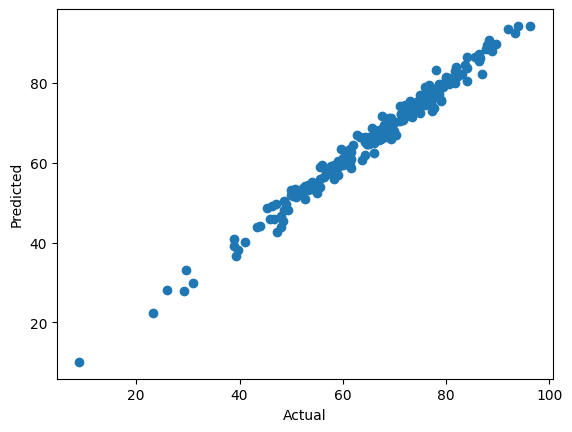

In [26]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

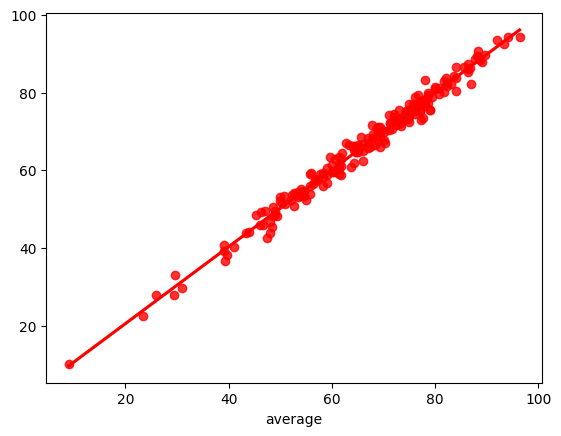

In [27]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [28]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,87.000000,82.109375,4.890625
737,64.000000,66.187500,-2.187500
740,75.000000,73.875000,1.125000
660,74.666667,75.515625,-0.848958
411,81.666667,82.937500,-1.270833
...,...,...,...
408,55.000000,52.296875,2.703125
332,57.000000,57.125000,-0.125000
208,77.000000,74.953125,2.046875
613,72.000000,72.640625,-0.640625
